# DeepSDF в картинках
## Проект к курсу «Дополнительные главы машинного обучения», Колодзей 599б

В этой тетрадке я перескажу основные идеи из статьи [DeepSDF: Learning Continuous Signed Distance Functions for Shape Representation](https://arxiv.org/abs/1901.05103). Зачем пересказ, когда есть сама статья? Затем, что тут есть код и сгенерированные им картинки!

В статье рассматриваются 3D-фигуры. В пересказе, для простоты, будут картинки про 2D-фигуры.

<img src="3Dvs2D.png">

Кроме того, фигуры у меня будут простые, а нейросети для их кодирования совсем неглубокие. Цель пересказа — не воспроизведение state-of-the-art результата, а наглядное представление идей статьи так, чтобы с ними можно было вот прям в тетрадке начать играть.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import optim

## Знаковая функция расстояния (SDF)

Итак, пусть у нас есть некоторая *фигура* (shape) в 3D или 2D. Как её вообще представить в компьютерно-читаемом виде? Человечество придумало много способов, например:

+ Облака точек (point cloud): хранить множество точек с поверхности фигуры (такие данные часто получаются с сенсоров)
+ Сетка (mesh): хранить приближение поверхности фигуры многоугольниками (чаще — треугольниками)
+ Воксели (voxels): для каждого кубика пространства хранить, занят он фигурой или нет

В статье рассматривается ещё один способ: кодирование с помощью *знаковой функцией расстояния* (signed distance function, SDF). Для точки $x$ снаружи фигуры её знаковая функция расстояния $sdf(x)$ — это расстояние $\rho(x, S)$ от этой точки до поверхности $S$ фигуры. Для точки внутри — это $-\rho(x, S)$, т. е. расстояние до поверхности, взятое со знаком минус.

$$sdf(x) = \begin{cases}
  \rho(x, S),  & \mbox{если } x \mbox{ снаружи} \\
  -\rho(x, S), & \mbox{если } x \mbox{ внутри}
\end{cases}$$

Давайте закодим фигуры-примеры: круги и многоугольники.

In [2]:
class Geometry:
    EPS = 1e-12
    """
    Класс-namespace с геометрическими функциями
    """
    def distance_from_segment_to_point(a, b, p):
        ans = min(np.linalg.norm(a - p), np.linalg.norm(b - p))
        if (np.linalg.norm(a - b) > Geometry.EPS 
            and np.dot(p - a, b - a) > Geometry.EPS 
            and np.dot(p - b, a - b) > Geometry.EPS):
            ans = abs(np.cross(p - a, b - a) / np.linalg.norm(b - a))
        return ans


class Shape:
    def sdf(self, p):
        pass
    
    
class Circle(Shape):
    
    def __init__(self, c, r):
        self.c = c
        self.r = r
    
    def sdf(self, p):
        return np.linalg.norm(p - self.c) - self.r
    
    
class Polygon(Shape):
    
    def __init__(self, v):
        self.v = v
    
    def sdf(self, p):
        return -self.distance(p) if self.point_is_inside(p) else self.distance(p)
    
    def point_is_inside(self, p):
        angle_sum = 0
        L = len(self.v)
        for i in range(L):
            a = self.v[i]
            b = self.v[(i + 1) % L]
            angle_sum += np.arctan2(np.cross(a - p, b - p), np.dot(a - p, b - p))
        return abs(angle_sum) > 1
            
    def distance(self, p):
        ans = Geometry.distance_from_segment_to_point(self.v[-1], self.v[0], p)
        for i in range(len(self.v) - 1):
            ans = min(ans, Geometry.distance_from_segment_to_point(self.v[i], self.v[i + 1], p))
        return ans

Напишем функцию, которая изображает знаковую функцию расстояния.

In [3]:
def plot_sdf(sdf_func):
    # See https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap-with-matplotlib
    COORDINATES_LINSPACE = np.linspace(-4, 4, 100)
    y, x = np.meshgrid(COORDINATES_LINSPACE, COORDINATES_LINSPACE)
    z = np.float_([[sdf_func(np.float_([x_, y_])) 
                    for y_ in  COORDINATES_LINSPACE] 
                    for x_ in COORDINATES_LINSPACE])
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    fig, ax = plt.subplots(figsize=(10, 10))
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    
    # я не умею показывать colorbar так, чтобы пропорции heatmap не исказились ._.
    # fig.colorbar(c, ax=ax)

Посмотрим на график для круга

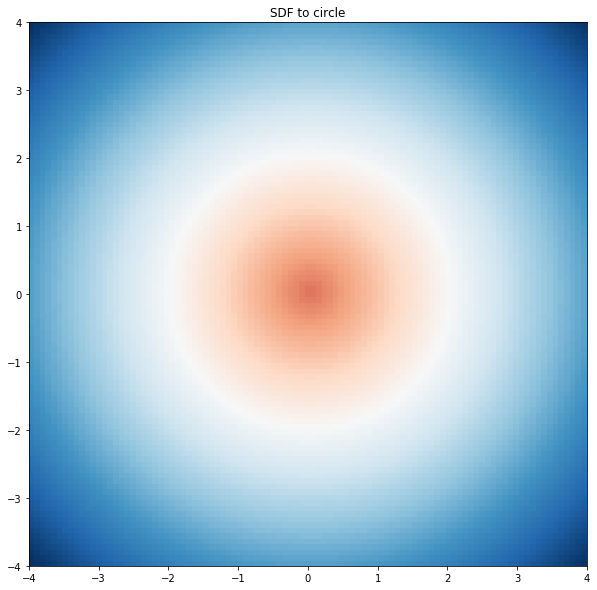

In [4]:
# круг с центром в начале координат и радиусом 2
circle = Circle(np.float_([0, 0]), 2)
plot_sdf(circle.sdf)
plt.title("SDF to circle")
plt.show()

И на график для прямоугольника

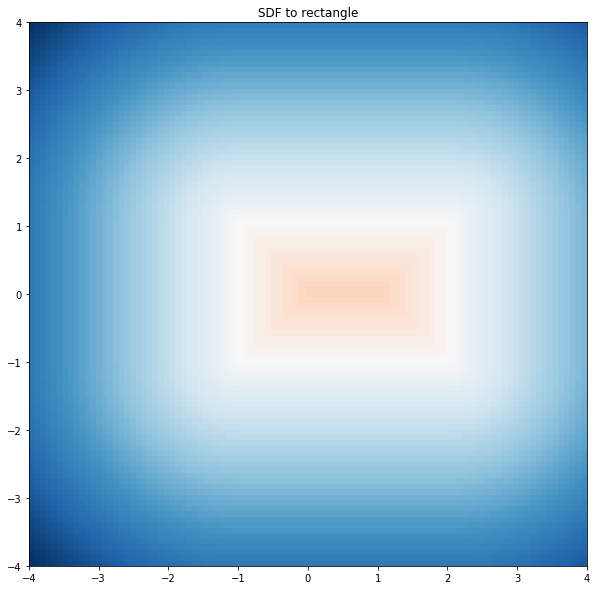

In [5]:
# многоугольник с вершинами в указанных точках
rectangle = Polygon(np.float_([[-1, -1], [-1, 1], [2, 1], [2, -1]]))
plot_sdf(rectangle.sdf)
plt.title("SDF to rectangle")
plt.show()

## Кодирование SDF с помощью нейронной сети

Давайте построим приближение знаковой функции расстояния одной конкретной фигуры (круга) с помощью нейросети. Например, простейшей нейросети с одним скрытым слоем.

<img src="architecture.png">

На входном слое этой неросети 2 нейрона: сеть принимает на вход координаты точки. На выходном слое один нейрон — знаковая функция расстояния до принятной на вход точки.

In [11]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.Tensor(x)
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


Сгенерируем обучающую выборку: значения знаковой функции расстояния для фигуры в наборе точек.

$$ TRAIN := \{((x, y), s) : SDF(x, y) = s\} $$

Точки выберем, равномерно просэмплировав знаковую функцию расстояния около фигуры.

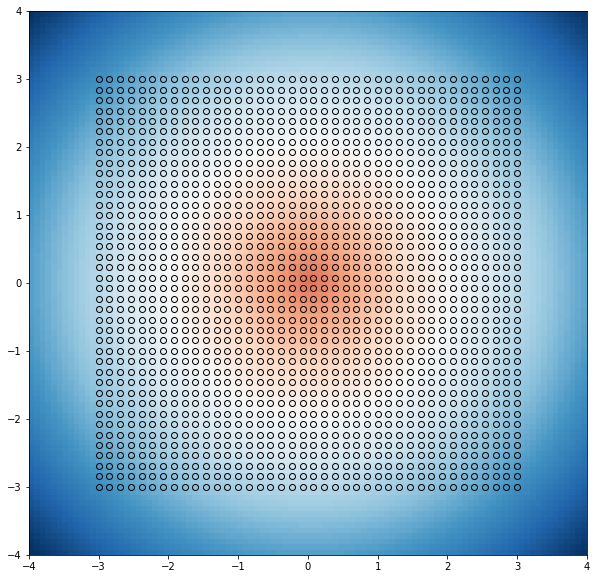

In [7]:
points_train = np.float_([[x_, y_] 
                    for y_ in  np.linspace(-3, 3, 40) 
                    for x_ in np.linspace(-3, 3, 40)])
sdf_train = np.float_(list(map(circle.sdf, points_train)))

plot_sdf(circle.sdf)
plt.scatter(points_train[:,0], points_train[:,1], color=(1, 1, 1, 0), edgecolor="#000000")

Для обучения нейросети будет удобно перевести данные в pytorch-формат. Заодно пошаффлим.

In [8]:
train_ds = TensorDataset(torch.Tensor(points_train), torch.Tensor(sdf_train))
train_dl = DataLoader(train_ds, shuffle=True, batch_size=len(train_ds))

В качестве функции потерь возьмём `l1_loss`.

$$ Loss(net(x, y), sdf(x, y)) = |net(x, y) - sdf(x, y)| $$

В оригинальной статье функция потерь чуть более хитрая и выглядит так:

$$ Loss(net(x, y), sdf(x, y)) = |clamp(net(x, y), \delta) - clamp(sdf(x, y), \delta)| $$

где $clamp(x, \delta) = min(\delta, max(-\delta, x))$

Такая хитрая функция потерь взята, чтобы сконцентировать выразительную способность нейросети около поверхности фигуры.


Epoch: 0 Loss: 0.806153416633606


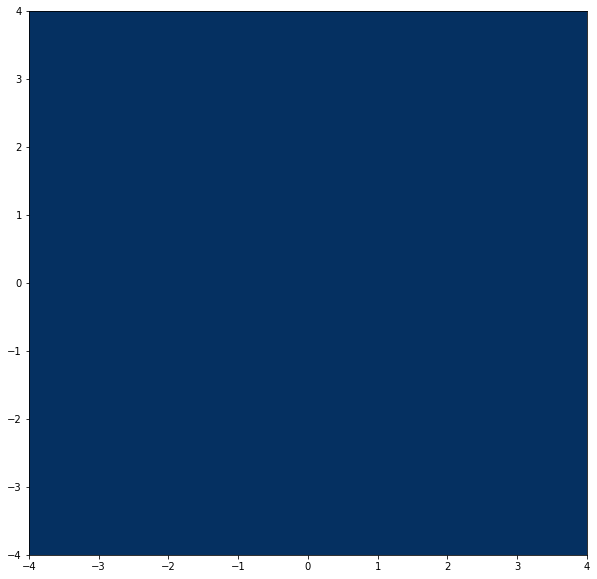

Epoch: 1 Loss: 0.8464353680610657
Epoch: 2 Loss: 0.8464252352714539
Epoch: 3 Loss: 0.84641432762146
Epoch: 4 Loss: 0.8464041352272034
Epoch: 5 Loss: 0.8463912010192871
Epoch: 6 Loss: 0.8463795185089111
Epoch: 7 Loss: 0.8463671803474426
Epoch: 8 Loss: 0.8463549017906189
Epoch: 9 Loss: 0.846341609954834
Epoch: 10 Loss: 0.8463280200958252
Epoch: 11 Loss: 0.846314013004303
Epoch: 12 Loss: 0.8462986946105957
Epoch: 13 Loss: 0.8462828993797302
Epoch: 14 Loss: 0.8462668657302856
Epoch: 15 Loss: 0.8462499976158142
Epoch: 16 Loss: 0.8462321758270264
Epoch: 17 Loss: 0.8462138175964355
Epoch: 18 Loss: 0.8461940884590149
Epoch: 19 Loss: 0.8461737036705017
Epoch: 20 Loss: 0.846150279045105
Epoch: 21 Loss: 0.8461290597915649
Epoch: 22 Loss: 0.8461048603057861
Epoch: 23 Loss: 0.8460798859596252
Epoch: 24 Loss: 0.8460521101951599
Epoch: 25 Loss: 0.8460238575935364
Epoch: 26 Loss: 0.8459935784339905
Epoch: 27 Loss: 0.8459616899490356
Epoch: 28 Loss: 0.8459287285804749
Epoch: 29 Loss: 0.8458922505378723

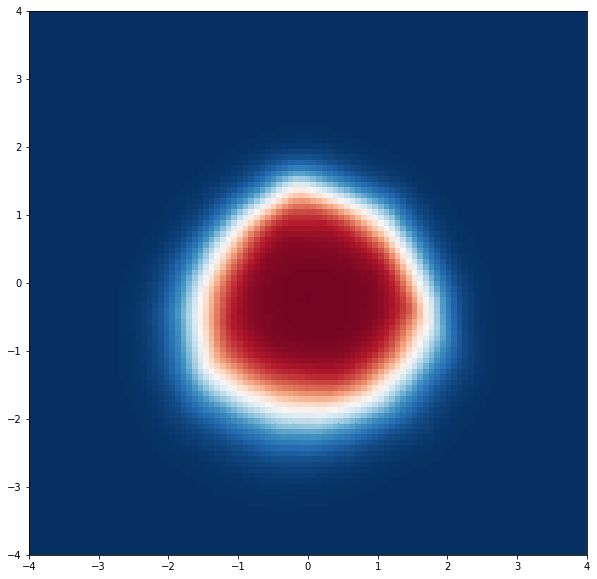

Epoch: 101 Loss: 0.41528356075286865
Epoch: 102 Loss: 0.35865336656570435
Epoch: 103 Loss: 0.3225014805793762
Epoch: 104 Loss: 0.32426509261131287
Epoch: 105 Loss: 0.45692282915115356
Epoch: 106 Loss: 0.3883749842643738
Epoch: 107 Loss: 0.3671301007270813
Epoch: 108 Loss: 0.317449152469635
Epoch: 109 Loss: 0.47299736738204956
Epoch: 110 Loss: 0.3398498594760895
Epoch: 111 Loss: 0.29039883613586426
Epoch: 112 Loss: 0.27319151163101196
Epoch: 113 Loss: 0.33790457248687744
Epoch: 114 Loss: 0.2795763313770294
Epoch: 115 Loss: 0.402260959148407
Epoch: 116 Loss: 0.26232191920280457
Epoch: 117 Loss: 0.2726123631000519
Epoch: 118 Loss: 0.2576083540916443
Epoch: 119 Loss: 0.32606714963912964
Epoch: 120 Loss: 0.3075806498527527
Epoch: 121 Loss: 0.46004581451416016
Epoch: 122 Loss: 0.29578953981399536
Epoch: 123 Loss: 0.24895279109477997
Epoch: 124 Loss: 0.2533365488052368
Epoch: 125 Loss: 0.34132853150367737
Epoch: 126 Loss: 0.306672602891922
Epoch: 127 Loss: 0.5011684894561768
Epoch: 128 Loss: 

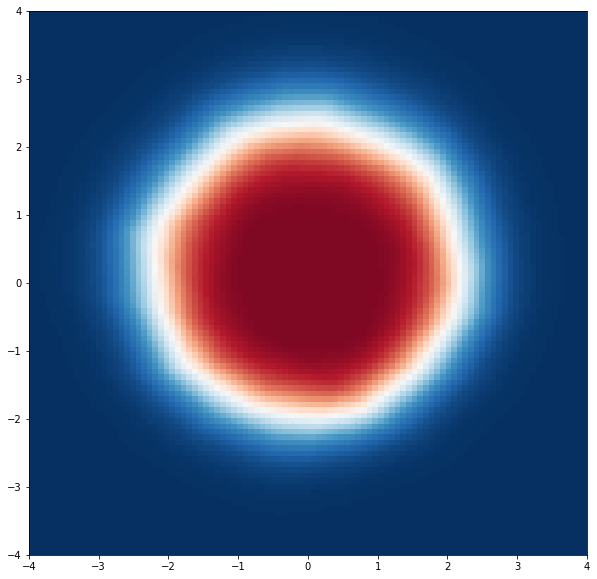

Epoch: 201 Loss: 0.26755428314208984
Epoch: 202 Loss: 0.31065472960472107
Epoch: 203 Loss: 0.2710542678833008
Epoch: 204 Loss: 0.3120673894882202
Epoch: 205 Loss: 0.26448002457618713
Epoch: 206 Loss: 0.3112329840660095
Epoch: 207 Loss: 0.2705708146095276
Epoch: 208 Loss: 0.31137609481811523
Epoch: 209 Loss: 0.2668269872665405
Epoch: 210 Loss: 0.3129286468029022
Epoch: 211 Loss: 0.2702594995498657
Epoch: 212 Loss: 0.3105775713920593
Epoch: 213 Loss: 0.2648376524448395
Epoch: 214 Loss: 0.3114756643772125
Epoch: 215 Loss: 0.26832306385040283
Epoch: 216 Loss: 0.3094739615917206
Epoch: 217 Loss: 0.26456964015960693
Epoch: 218 Loss: 0.31010890007019043
Epoch: 219 Loss: 0.26899632811546326
Epoch: 220 Loss: 0.30872881412506104
Epoch: 221 Loss: 0.26507270336151123
Epoch: 222 Loss: 0.3101271390914917
Epoch: 223 Loss: 0.26854759454727173
Epoch: 224 Loss: 0.3077889382839203
Epoch: 225 Loss: 0.2619709372520447
Epoch: 226 Loss: 0.3103547990322113
Epoch: 227 Loss: 0.2690344452857971
Epoch: 228 Loss: 

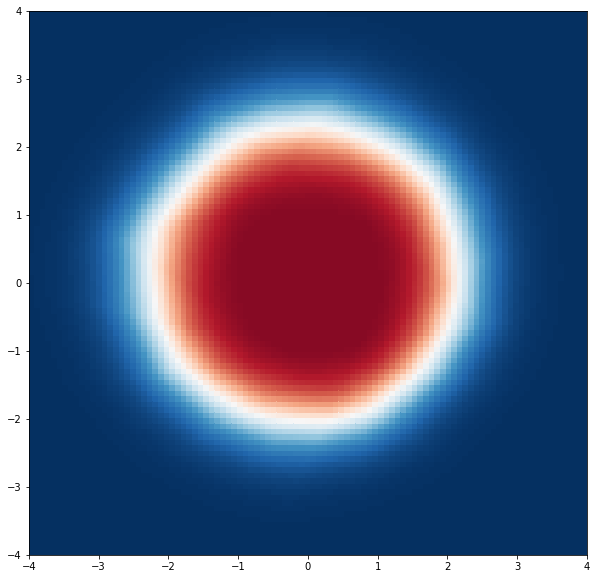

Epoch: 301 Loss: 0.2638288736343384
Epoch: 302 Loss: 0.32437801361083984
Epoch: 303 Loss: 0.2599601149559021
Epoch: 304 Loss: 0.2865768074989319
Epoch: 305 Loss: 0.26272451877593994
Epoch: 306 Loss: 0.3245460093021393
Epoch: 307 Loss: 0.25982287526130676
Epoch: 308 Loss: 0.28183457255363464
Epoch: 309 Loss: 0.2598057687282562
Epoch: 310 Loss: 0.3246210217475891
Epoch: 311 Loss: 0.25752881169319153
Epoch: 312 Loss: 0.2816382944583893
Epoch: 313 Loss: 0.26311957836151123
Epoch: 314 Loss: 0.32723695039749146
Epoch: 315 Loss: 0.2583073079586029
Epoch: 316 Loss: 0.2803349196910858
Epoch: 317 Loss: 0.25657016038894653
Epoch: 318 Loss: 0.32269957661628723
Epoch: 319 Loss: 0.2590499818325043
Epoch: 320 Loss: 0.28825873136520386
Epoch: 321 Loss: 0.26344579458236694
Epoch: 322 Loss: 0.3213712275028229
Epoch: 323 Loss: 0.25735709071159363
Epoch: 324 Loss: 0.28124120831489563
Epoch: 325 Loss: 0.2578130066394806
Epoch: 326 Loss: 0.3232994079589844
Epoch: 327 Loss: 0.25688454508781433
Epoch: 328 Los

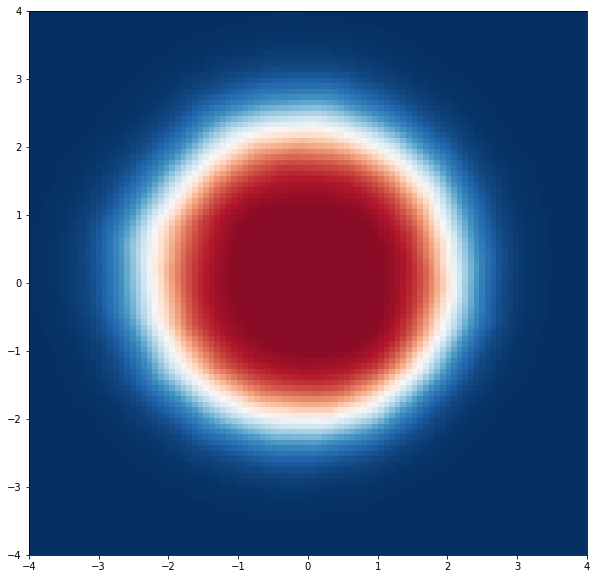

Epoch: 401 Loss: 0.26137208938598633
Epoch: 402 Loss: 0.28905490040779114
Epoch: 403 Loss: 0.25659453868865967
Epoch: 404 Loss: 0.3082759380340576
Epoch: 405 Loss: 0.2629142701625824
Epoch: 406 Loss: 0.29275938868522644
Epoch: 407 Loss: 0.2550676465034485
Epoch: 408 Loss: 0.3057068884372711
Epoch: 409 Loss: 0.25906968116760254
Epoch: 410 Loss: 0.29191094636917114
Epoch: 411 Loss: 0.25683411955833435
Epoch: 412 Loss: 0.3069499731063843
Epoch: 413 Loss: 0.25976088643074036
Epoch: 414 Loss: 0.28961464762687683
Epoch: 415 Loss: 0.2578807771205902
Epoch: 416 Loss: 0.30586254596710205
Epoch: 417 Loss: 0.2577412724494934
Epoch: 418 Loss: 0.2920532524585724
Epoch: 419 Loss: 0.2575776278972626
Epoch: 420 Loss: 0.30558452010154724
Epoch: 421 Loss: 0.25833001732826233
Epoch: 422 Loss: 0.29204869270324707
Epoch: 423 Loss: 0.2568258047103882
Epoch: 424 Loss: 0.3050413727760315
Epoch: 425 Loss: 0.25349387526512146
Epoch: 426 Loss: 0.28774455189704895
Epoch: 427 Loss: 0.2576957643032074
Epoch: 428 Lo

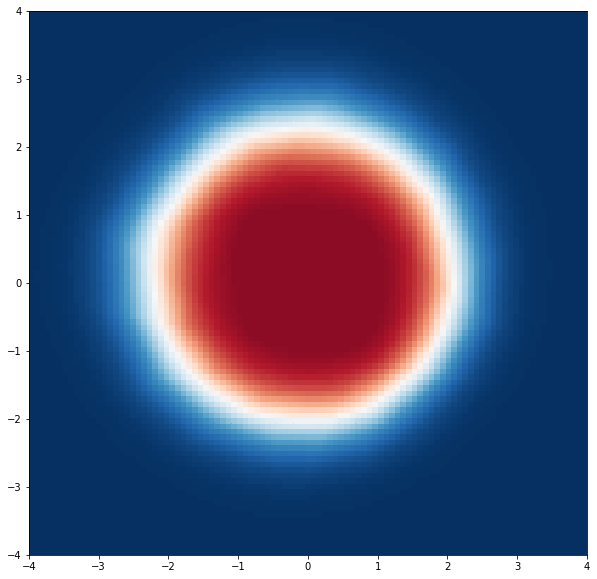

Epoch: 501 Loss: 0.2561102509498596
Epoch: 502 Loss: 0.2884892523288727
Epoch: 503 Loss: 0.2555222809314728
Epoch: 504 Loss: 0.3043520152568817
Epoch: 505 Loss: 0.25303635001182556
Epoch: 506 Loss: 0.2858124077320099
Epoch: 507 Loss: 0.2562887966632843
Epoch: 508 Loss: 0.3061896562576294
Epoch: 509 Loss: 0.2575933337211609
Epoch: 510 Loss: 0.28862836956977844
Epoch: 511 Loss: 0.25576770305633545
Epoch: 512 Loss: 0.3051961660385132
Epoch: 513 Loss: 0.25597476959228516
Epoch: 514 Loss: 0.2901366353034973
Epoch: 515 Loss: 0.2550851106643677
Epoch: 516 Loss: 0.30394813418388367
Epoch: 517 Loss: 0.25306379795074463
Epoch: 518 Loss: 0.2862923741340637
Epoch: 519 Loss: 0.25659847259521484
Epoch: 520 Loss: 0.30620551109313965
Epoch: 521 Loss: 0.2586526870727539
Epoch: 522 Loss: 0.29205259680747986
Epoch: 523 Loss: 0.2526589632034302
Epoch: 524 Loss: 0.3012137711048126
Epoch: 525 Loss: 0.2537685036659241
Epoch: 526 Loss: 0.2893220782279968
Epoch: 527 Loss: 0.2547464072704315
Epoch: 528 Loss: 0.

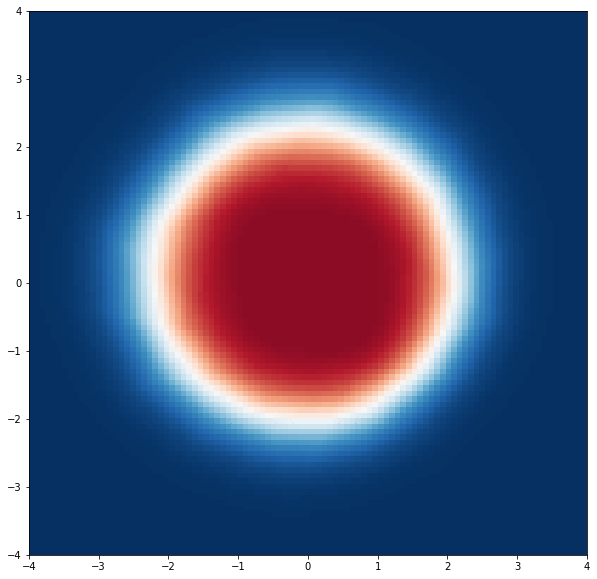

Epoch: 601 Loss: 0.25620341300964355
Epoch: 602 Loss: 0.28717800974845886
Epoch: 603 Loss: 0.25470107793807983
Epoch: 604 Loss: 0.2989615499973297
Epoch: 605 Loss: 0.2578863203525543
Epoch: 606 Loss: 0.29245680570602417
Epoch: 607 Loss: 0.2546699643135071
Epoch: 608 Loss: 0.2956937551498413
Epoch: 609 Loss: 0.25648200511932373
Epoch: 610 Loss: 0.2934296131134033
Epoch: 611 Loss: 0.2573458254337311
Epoch: 612 Loss: 0.2984667718410492
Epoch: 613 Loss: 0.25269508361816406
Epoch: 614 Loss: 0.2890283167362213
Epoch: 615 Loss: 0.253350168466568
Epoch: 616 Loss: 0.2921295464038849
Epoch: 617 Loss: 0.259269118309021
Epoch: 618 Loss: 0.30058443546295166
Epoch: 619 Loss: 0.2536877691745758
Epoch: 620 Loss: 0.28605371713638306
Epoch: 621 Loss: 0.25757208466529846
Epoch: 622 Loss: 0.297569215297699
Epoch: 623 Loss: 0.25500592589378357
Epoch: 624 Loss: 0.2951648235321045
Epoch: 625 Loss: 0.2552780210971832
Epoch: 626 Loss: 0.2885478138923645
Epoch: 627 Loss: 0.2550216615200043
Epoch: 628 Loss: 0.30

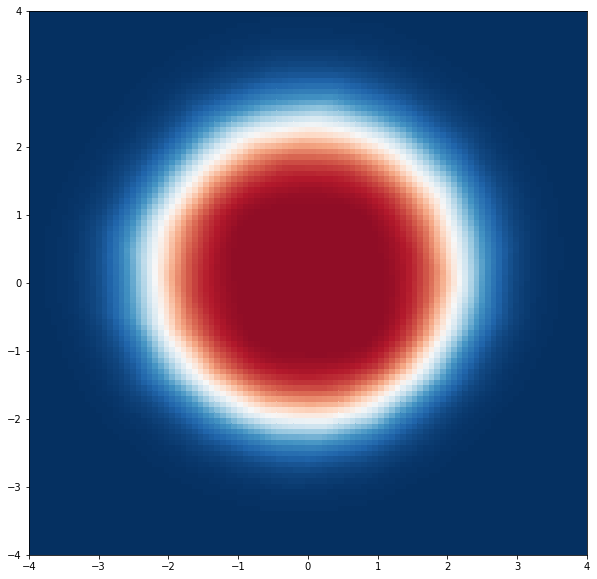

Epoch: 701 Loss: 0.25693920254707336
Epoch: 702 Loss: 0.2948054075241089
Epoch: 703 Loss: 0.25300562381744385
Epoch: 704 Loss: 0.28702595829963684
Epoch: 705 Loss: 0.25357726216316223
Epoch: 706 Loss: 0.29878389835357666
Epoch: 707 Loss: 0.2549678683280945
Epoch: 708 Loss: 0.29198238253593445
Epoch: 709 Loss: 0.25515472888946533
Epoch: 710 Loss: 0.2956232726573944
Epoch: 711 Loss: 0.2537429630756378
Epoch: 712 Loss: 0.2908264100551605
Epoch: 713 Loss: 0.25575926899909973
Epoch: 714 Loss: 0.2974191904067993
Epoch: 715 Loss: 0.25376540422439575
Epoch: 716 Loss: 0.2883972227573395
Epoch: 717 Loss: 0.25297579169273376
Epoch: 718 Loss: 0.2950974404811859
Epoch: 719 Loss: 0.25303131341934204
Epoch: 720 Loss: 0.2926825284957886
Epoch: 721 Loss: 0.25628405809402466
Epoch: 722 Loss: 0.2961948812007904
Epoch: 723 Loss: 0.25279662013053894
Epoch: 724 Loss: 0.2934916317462921
Epoch: 725 Loss: 0.2547673285007477
Epoch: 726 Loss: 0.293030709028244
Epoch: 727 Loss: 0.25391852855682373
Epoch: 728 Loss

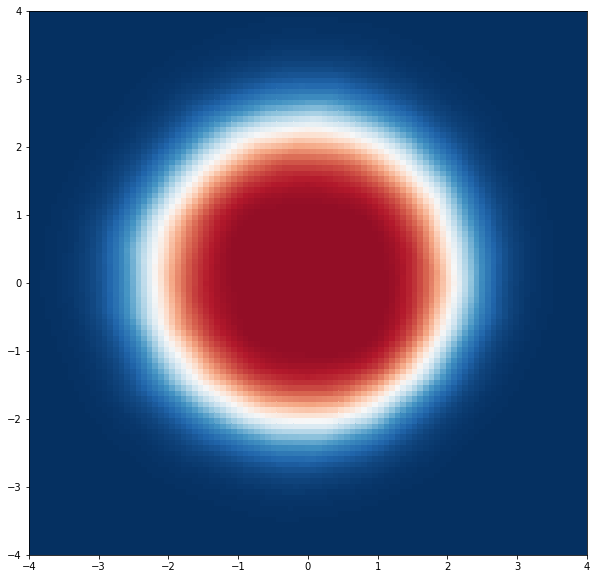

Epoch: 801 Loss: 0.2521941065788269
Epoch: 802 Loss: 0.28948262333869934
Epoch: 803 Loss: 0.2540973126888275
Epoch: 804 Loss: 0.29487472772598267
Epoch: 805 Loss: 0.2517574429512024
Epoch: 806 Loss: 0.2894352972507477
Epoch: 807 Loss: 0.25414881110191345
Epoch: 808 Loss: 0.2962909936904907
Epoch: 809 Loss: 0.2508876621723175
Epoch: 810 Loss: 0.2840704321861267
Epoch: 811 Loss: 0.2573632001876831
Epoch: 812 Loss: 0.30198532342910767
Epoch: 813 Loss: 0.2557240128517151
Epoch: 814 Loss: 0.285923570394516
Epoch: 815 Loss: 0.2557511627674103
Epoch: 816 Loss: 0.2969531714916229
Epoch: 817 Loss: 0.24952220916748047
Epoch: 818 Loss: 0.2831225097179413
Epoch: 819 Loss: 0.2581709921360016
Epoch: 820 Loss: 0.3053683042526245
Epoch: 821 Loss: 0.25777655839920044
Epoch: 822 Loss: 0.2848266661167145
Epoch: 823 Loss: 0.2536998689174652
Epoch: 824 Loss: 0.2941051423549652
Epoch: 825 Loss: 0.25092262029647827
Epoch: 826 Loss: 0.28657791018486023
Epoch: 827 Loss: 0.2563340663909912
Epoch: 828 Loss: 0.30

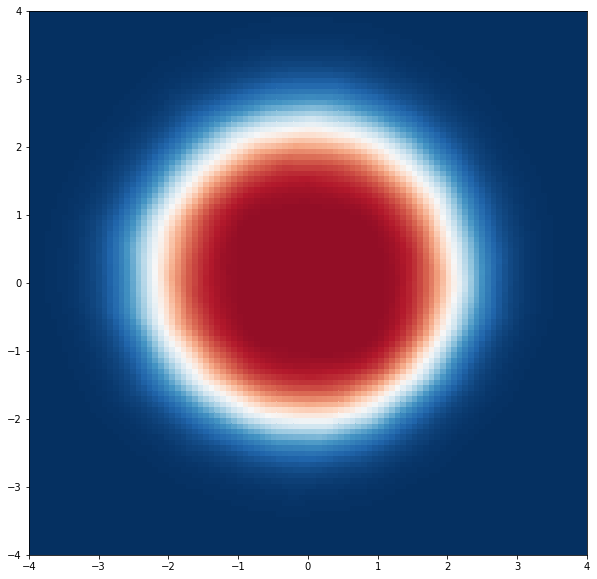

Epoch: 901 Loss: 0.2510753870010376
Epoch: 902 Loss: 0.2806360423564911
Epoch: 903 Loss: 0.25403815507888794
Epoch: 904 Loss: 0.3003804087638855
Epoch: 905 Loss: 0.25338467955589294
Epoch: 906 Loss: 0.2841264009475708
Epoch: 907 Loss: 0.2510264813899994
Epoch: 908 Loss: 0.29764077067375183
Epoch: 909 Loss: 0.2520865797996521
Epoch: 910 Loss: 0.2888597249984741
Epoch: 911 Loss: 0.2541944086551666
Epoch: 912 Loss: 0.2954879105091095
Epoch: 913 Loss: 0.25360485911369324
Epoch: 914 Loss: 0.28914037346839905
Epoch: 915 Loss: 0.25402554869651794
Epoch: 916 Loss: 0.2959829270839691
Epoch: 917 Loss: 0.25257864594459534
Epoch: 918 Loss: 0.2852490544319153
Epoch: 919 Loss: 0.2523542642593384
Epoch: 920 Loss: 0.3011356592178345
Epoch: 921 Loss: 0.25637292861938477
Epoch: 922 Loss: 0.2861839532852173
Epoch: 923 Loss: 0.2501935660839081
Epoch: 924 Loss: 0.29052048921585083
Epoch: 925 Loss: 0.25401559472084045
Epoch: 926 Loss: 0.2902246415615082
Epoch: 927 Loss: 0.2529245615005493
Epoch: 928 Loss: 0

In [12]:
net = Net()
epochs = 1000
delta = 10
opt = optim.SGD(net.parameters(), lr=1)
for epoch in range(epochs):
    net.train()
    total_loss = 0
    for points_b, sdfs_b in train_dl:
        pred = net(points_b)
        # print("a", a.shape, a)
        # print("sdfs_b", sdfs_b.shape, sdfs_b)
        # print("pred", pred.shape, pred)
        # print(pred.shape)
        pred = pred.squeeze()
        # print(pred.shape)
        # print(sdfs_b.shape)
        loss = F.l1_loss(pred, sdfs_b)
        total_loss += loss
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    print("Epoch:", epoch, "Loss:", total_loss.item())
    
    if (epoch % 100 == 0):
        plot_sdf(net.forward)
    #    plot_sdf(circle.sdf)
        plt.show()
   
    

## Вычисление нормали из backpropagation

Заметим, что мы можем посчитать нормаль в точке на поверхности, используя backpropagation. Действительно, нормаль — это направление градиента знаковой функции расстояния. Поэтому посчитать нормаль можно так:

In [13]:
p = torch.Tensor([0, -2])
p.requires_grad=True
my_sdf = net(p)
my_sdf.backward()
print(p.grad)

tensor([-0.0196, -1.6315])


Нарисуем вектор нормали на графике.

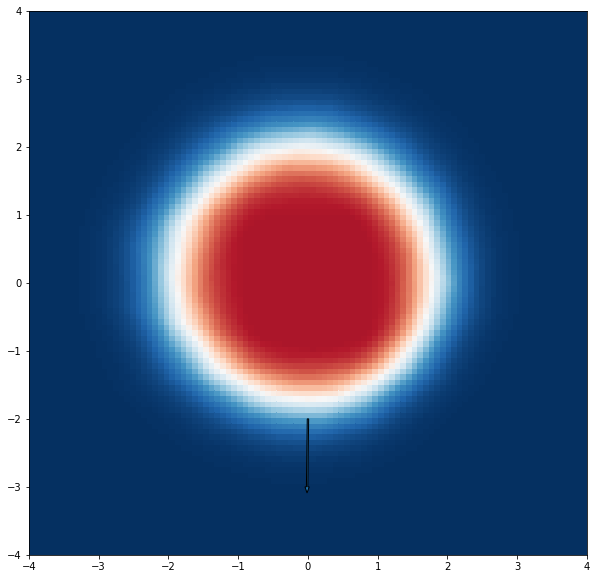

In [14]:
plot_sdf(net.forward)
plt.arrow(*p, *p.grad / np.linalg.norm(p.grad), width=0.02)